# PARTIE 5 : Analyse des Transactions Bancaires

## 1. Poser la Question / Business Understanding

L'objectif de cette analyse est de comprendre le comportement transactionnel des clients d'une banque fictive au Cameroun. Nous cherchons à répondre aux questions suivantes :

*   **Analyse Descriptive :**
     *   Quels sont les montants totaux des crédits et débits ?
     *   Quel est le solde moyen par client ?
     *   Comment les transactions se répartissent-elles par canal ?
     *   Quel est le montant moyen des transactions par type de compte ?
*   **Analyse Business :**
     *   Qui sont les 10 clients les plus actifs (selon différentes définitions) ?
     *   Quelle ville génère le plus de transactions ?
     *   Y a-t-il une différence de comportement transactionnel entre les hommes et les femmes ?
*   **Visualisation :** Fournir des graphiques clairs sur:
     *    le volume mensuel,
     *    la répartition par canal
     *    le top 10 des clients.

Ces insights aideront la banque à mieux comprendre sa clientèle, à optimiser ses canaux et à développer des stratégies de fidélisation ciblées.



## 2. Collecte des Données

Chargement des bibliothèques utiles et du fichier CSV.

In [55]:
#Imporatation des packages nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration pour de meilleurs graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Charger les données
df_trans = pd.read_csv('bank_transactions_cameroon_-_PARTIE_5_Cas_pratique_3.csv')

# Aperçu des données
print("\nAperçu des données de transaction :")
print(df_trans.head())
print("\n\nInformations sur les données :")
print(df_trans.info())


Aperçu des données de transaction :
  transaction_id        date account_id client_id       client_name gender  \
0       TXN00001  2025-11-07   ACC10203    CL1203     Didier Mbarga      M   
1       TXN00002  2025-11-10   ACC10248    CL1248   Emmanuel Mballa      M   
2       TXN00003  2025-11-12   ACC10243    CL1243  Clarisse Essomba      F   
3       TXN00004  2025-09-18   ACC10279    CL1279   Clarisse Mballa      F   
4       TXN00005  2025-01-09   ACC10124    CL1124    Chantal Mballa      F   

   age account_type transaction_type  amount channel     city  balance_after  
0   43      Savings           Credit   79087  Mobile   Garoua         723097  
1   48      Current           Credit  489305  Online  Yaoundé        1043804  
2   30      Savings            Debit  207021  Online   Douala         444608  
3   33      Current           Credit  266979  Branch  Bamenda         579480  
4   53      Current           Credit  249980  Online  Bamenda        1218026  


Informations sur l

## 3. Enquête et Préparation des Données (Data Cleaning)

In [56]:
# 1. Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df_trans.isnull().sum())


Valeurs manquantes par colonne :
transaction_id      0
date                0
account_id          0
client_id           0
client_name         0
gender              0
age                 0
account_type        0
transaction_type    0
amount              0
channel             0
city                0
balance_after       0
dtype: int64


In [57]:
# 2. Vérifier les doublons (sur transaction_id, censé être unique)
print(f"\nNombre de doublons sur l'ID de transaction : {df_trans['transaction_id'].duplicated().sum()}")


Nombre de doublons sur l'ID de transaction : 0


In [58]:
# 3. Vérifier et corriger les types de données
# Convertir la colonne 'date' en format datetime
df_trans['date'] = pd.to_datetime(df_trans['date'])
# Vérifier que les colonnes numériques sont bien des nombres
df_trans['amount'] = pd.to_numeric(df_trans['amount'])
df_trans['balance_after'] = pd.to_numeric(df_trans['balance_after'])

print("\nTypes de données après correction :")
print(df_trans.dtypes)


Types de données après correction :
transaction_id                 str
date                datetime64[us]
account_id                     str
client_id                      str
client_name                    str
gender                         str
age                          int64
account_type                   str
transaction_type               str
amount                       int64
channel                        str
city                           str
balance_after                int64
dtype: object


In [59]:
# Vérification de la cohérence des transactions de crédit
# (le solde après doit être >= montant crédité)

resultats = {}

# Crédits
credits = df_trans[df_trans['transaction_type'] == 'Credit']
resultats['total_credits'] = len(credits)
resultats['credits_coherents'] = (credits['balance_after'] >= credits['amount']).sum()
resultats['credits_incoherents'] = resultats['total_credits'] - resultats['credits_coherents']

# Débits
debits = df_trans[df_trans['transaction_type'] == 'Debit']
resultats['total_debits'] = len(debits)
resultats['debits_solde_positif'] = (debits['balance_after'] >= 0).sum()
resultats['debits_solde_zero'] = (debits['balance_after'] == 0).sum()
resultats['debits_solde_negatif'] = (debits['balance_after'] < 0).sum()
    

print("Contrôle qualité des transactions:")
print(f"   {resultats['credits_incoherents']} transactions de crédit inchohérents")
print(f"   {resultats['debits_solde_zero']} transactions de débit ont vidé le compte (solde=0)")
print(f"   {resultats['debits_solde_negatif']} transactions de débit avec solde négatif")


Contrôle qualité des transactions:
   0 transactions de crédit inchohérents
   47 transactions de débit ont vidé le compte (solde=0)
   0 transactions de débit avec solde négatif



Statistiques descriptives des montants de transaction :
count      2000.000000
mean     205421.036000
std      130180.127997
min        1284.000000
25%       95272.250000
50%      196758.500000
75%      287692.000000
max      499630.000000
Name: amount, dtype: float64


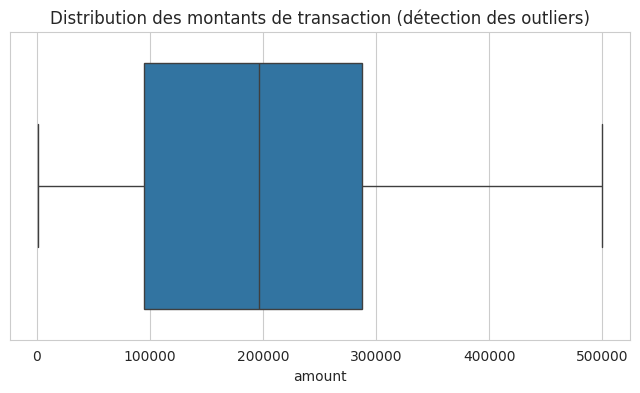

In [60]:
# 4. Analyse rapide des valeurs aberrantes (outliers) sur les montants
print("\nStatistiques descriptives des montants de transaction :")
print(df_trans['amount'].describe())

# Création d'un boxplot pour visualiser les outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=df_trans['amount'])
plt.title('Distribution des montants de transaction (détection des outliers)')
plt.show()

# Note: Des outliers existent (montants élevés), ce qui est normal pour des transactions bancaires.
# Nous ne les supprimerons pas pour l'instant, mais nous en tiendrons compte dans l'analyse.

## 4. Analyse des Données


### Partie 1 - Analyse Descriptive

In [61]:
# 1. Montant total des crédits et des débits
total_credit = df_trans[df_trans['transaction_type'] == 'Credit']['amount'].sum()
total_debit = df_trans[df_trans['transaction_type'] == 'Debit']['amount'].sum()

print(f"\n--- Analyse Descriptive ---")
print(f"Montant total des CRÉDITS : {total_credit:,.0f} FCFA")
print(f"Montant total des DÉBITS : {total_debit:,.0f} FCFA")
print(f"Volume total d'argent transité : {total_credit + total_debit:,.0f} FCFA")

# 2. Solde moyen par client
# Il faut d'abord trouver le dernier solde de chaque client pour être précis.
# Nous prenons le solde après la dernière transaction de chaque client.
last_transaction_per_client = df_trans.sort_values('date').groupby('client_id').last().reset_index()
average_balance = last_transaction_per_client['balance_after'].mean()
print(f"\nSolde moyen par client (basé sur le dernier solde connu) : {average_balance:,.0f} FCFA")

# 3. Répartition des transactions par canal
channel_counts = df_trans['channel'].value_counts()
channel_percentages = (channel_counts / len(df_trans)) * 100
print(f"\nRépartition des transactions par canal :")
print(channel_percentages.to_string(float_format='%.2f%%'))

# 4. Montant moyen des transactions par type de compte
avg_amount_by_account = df_trans.groupby('account_type')['amount'].mean().round(0)
print(f"\nMontant moyen des transactions par type de compte :")
print(avg_amount_by_account.to_string(float_format='%.0f FCFA'))

# Moyenne des montants par type de compte ET par type de transaction
avg_by_account_and_type = df_trans.groupby(['account_type', 'transaction_type'])['amount'].mean().round(0).unstack()
print("\n📊 DÉTAIL :")
print(f"Comptes COURANTS (Current) :")
print(f"  • Crédit moyen : {avg_by_account_and_type.loc['Current', 'Credit']:,.0f} FCFA")
print(f"  • Débit moyen  : {avg_by_account_and_type.loc['Current', 'Debit']:,.0f} FCFA")
print(f"  • Écart Crédit/Débit : {avg_by_account_and_type.loc['Current', 'Credit'] - avg_by_account_and_type.loc['Current', 'Debit']:,.0f} FCFA")

print(f"\nComptes ÉPARGNE (Savings) :")
print(f"  • Crédit moyen : {avg_by_account_and_type.loc['Savings', 'Credit']:,.0f} FCFA")
print(f"  • Débit moyen  : {avg_by_account_and_type.loc['Savings', 'Debit']:,.0f} FCFA")
print(f"  • Écart Crédit/Débit : {avg_by_account_and_type.loc['Savings', 'Credit'] - avg_by_account_and_type.loc['Savings', 'Debit']:,.0f} FCFA")


--- Analyse Descriptive ---
Montant total des CRÉDITS : 255,862,240 FCFA
Montant total des DÉBITS : 154,979,832 FCFA
Volume total d'argent transité : 410,842,072 FCFA

Solde moyen par client (basé sur le dernier solde connu) : 1,087,533 FCFA

Répartition des transactions par canal :
channel
Mobile   26.65%
Branch   25.05%
Online   24.45%
ATM      23.85%

Montant moyen des transactions par type de compte :
account_type
Current   206377 FCFA
Savings   204332 FCFA

📊 DÉTAIL :
Comptes COURANTS (Current) :
  • Crédit moyen : 260,441 FCFA
  • Débit moyen  : 155,753 FCFA
  • Écart Crédit/Débit : 104,688 FCFA

Comptes ÉPARGNE (Savings) :
  • Crédit moyen : 261,796 FCFA
  • Débit moyen  : 147,480 FCFA
  • Écart Crédit/Débit : 114,316 FCFA


### Partie 2 - Analyse Business

In [62]:
# --- Clients les plus actifs ---
print(f"\n--- Analyse Business ---")

# Calculer les métriques d'activité par client
client_activity = df_trans.groupby(['client_id', 'client_name', 'gender', 'city']).agg(
    tx_count=('transaction_id', 'count'),
    total_credit_volume=('amount', lambda x: x[df_trans.loc[x.index, 'transaction_type'] == 'Credit'].sum()),
    total_debit_volume=('amount', lambda x: x[df_trans.loc[x.index, 'transaction_type'] == 'Debit'].sum()),
    unique_channels=('channel', 'nunique')
).reset_index()

# 1. Volume Financier Total (Somme de tous les montants crédités et débités)
client_activity['total_financial_volume'] = client_activity['total_credit_volume'] + client_activity['total_debit_volume']

# Top 10 par volume financier
top_10_by_volume = client_activity.nlargest(10, 'total_financial_volume')[['client_name', 'city', 'total_financial_volume', 'tx_count']]
print("\nTop 10 clients par volume financier total transité :")
print(top_10_by_volume.to_string(index=False))

# 2. Top 10 par fréquence (nombre de transactions)
top_10_by_frequency = client_activity.nlargest(10, 'tx_count')[['client_name', 'city', 'tx_count', 'total_financial_volume']]
print("\nTop 10 clients par nombre de transactions :")
print(top_10_by_frequency.to_string(index=False))

# 3. Top 10 par diversité des canaux (clients engagés)
top_10_by_channels = client_activity.nlargest(10, 'unique_channels')[['client_name', 'city', 'unique_channels', 'tx_count']]
print("\nTop 10 clients par diversité de canaux utilisés :")
print(top_10_by_channels.to_string(index=False))

# L'activité d'un client est évalué sous 3 angle 
    #- La Fréquence (Nombre de transactions) : Le client qui utilise sa banque tous les jours (même pour de petits montants). 
    # - Le Volume Financier (Somme des transactions) : Le client qui fait transiter le plus d'argent (somme des débits + somme des crédits). 
    #- La Diversité des Canaux : Un client qui utilise à la fois le Mobile, l'ATM et l'Online est considéré comme plus "engagé" numériquement. nous devons prendre encompte ces

# Normalisation des scores (pour mettre les 3 critères sur une échelle comparable)
# On utilise le rang (rank) car c'est plus robuste aux valeurs extrêmes
client_activity['score_volume'] = client_activity['total_financial_volume'].rank(pct=True)
client_activity['score_freq'] = client_activity['tx_count'].rank(pct=True)
client_activity['score_channels'] = client_activity['unique_channels'].rank(pct=True)

# 2. Calcul du Score Global d'Activité
# Vous pouvez ajuster les poids (ex: 0.5 pour la fréquence si c'est plus important pour vous)
client_activity['global_activity_score'] = (
    client_activity['score_volume']  + 
    client_activity['score_freq']  + 
    client_activity['score_channels'] 
)

# 3. Top 10 des clients les plus actifs (Omnicanaux, réguliers et à fort volume)
top_10_globaux = client_activity.nlargest(10, 'global_activity_score')[
    ['client_name', 'city', 'tx_count', 'total_financial_volume', 'unique_channels', 'global_activity_score']
]

print("\n🏆 TOP 10 DES CLIENTS LES PLUS ACTIFS (SCORE COMBINÉ) :")
print(top_10_globaux.to_string(index=False))
# --- Analyse par Ville ---
city_stats = df_trans.groupby('city').agg(
    total_transactions=('transaction_id', 'count'),
    total_volume=('amount', 'sum')
).sort_values('total_volume', ascending=False)
print(f"\n\nVille générant le plus de transactions (par volume) : **{city_stats.index[0]}**")
print(city_stats)

# --- Analyse par Canal ---
channel_stats = df_trans['channel'].value_counts()
print(f"\nCanal le plus utilisé : **{channel_stats.index[0]}** ({channel_stats.iloc[0]} transactions)")

# --- Différence Homme/Femme ---
gender_analysis = df_trans.groupby('gender').agg(
    avg_transaction_amount=('amount', 'mean'),
    total_volume=('amount', 'sum'),
    transaction_count=('transaction_id', 'count')
).round(0)
print(f"\nAnalyse du comportement transactionnel par genre :")
print(gender_analysis)

# Interprétation : On observe que les hommes ont un montant moyen de transaction plus élevé,
# mais les femmes effectuent presque autant de transactions au total. Cela suggère des comportements
# légèrement différents, mais les deux genres sont des segments clés.


--- Analyse Business ---

Top 10 clients par volume financier total transité :
      client_name      city  total_financial_volume  tx_count
      Nadine Nkou   Bamenda                 3587801        13
  Emmanuel Mballa   Bamenda                 3158069        10
    Brigitte Etoa    Douala                 2953200        11
     Serge Mballa    Garoua                 2908918        13
   Emmanuel Ngono   Yaoundé                 2893925        11
   Solange Mballa    Garoua                 2811228        12
      Didier Nana Bafoussam                 2765675        12
        Paul Nkou    Douala                 2759113        11
Brigitte Atangana Bafoussam                 2720962        10
 Estelle Atangana Bafoussam                 2654479        12

Top 10 clients par nombre de transactions :
     client_name      city  tx_count  total_financial_volume
    Serge Mballa    Garoua        13                 2908918
     Nadine Nkou   Bamenda        13                 3587801
 Clarisse 

## 5. Visualisation

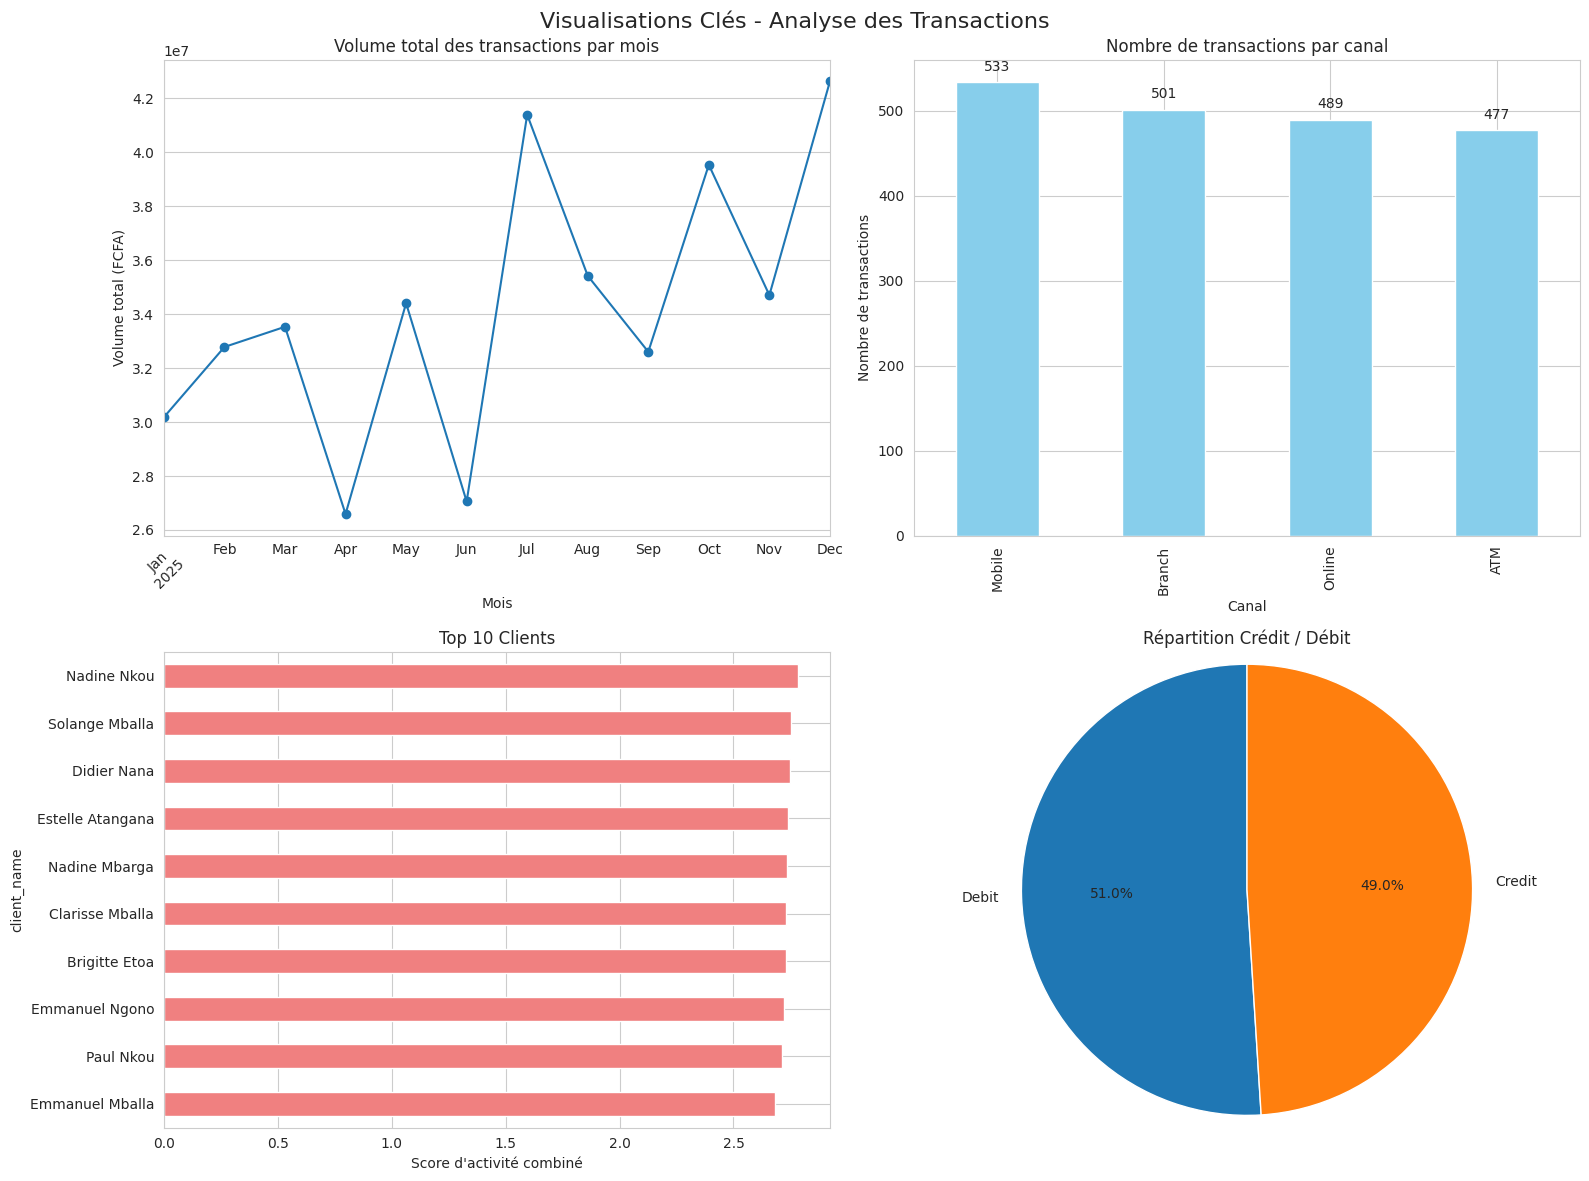

In [63]:
# Configuration des sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Visualisations Clés - Analyse des Transactions', fontsize=16)

# 1. Volume par Mois
df_trans['month'] = df_trans['date'].dt.to_period('M')
monthly_volume = df_trans.groupby('month')['amount'].sum().sort_index()
monthly_volume.plot(kind='line', marker='o', ax=axes[0,0])
axes[0,0].set_title('Volume total des transactions par mois')
axes[0,0].set_xlabel('Mois')
axes[0,0].set_ylabel('Volume total (FCFA)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Transactions par Canal
channel_counts.plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Nombre de transactions par canal')
axes[0,1].set_xlabel('Canal')
axes[0,1].set_ylabel('Nombre de transactions')
for i, v in enumerate(channel_counts):
    axes[0,1].text(i, v + 10, str(v), ha='center', va='bottom')

# 3. Top 10 Clients
top_10_plot = top_10_globaux.set_index('client_name')['global_activity_score'].sort_values().plot(kind='barh', ax=axes[1,0], color='lightcoral')
axes[1,0].set_title('Top 10 Clients')
axes[1,0].set_xlabel("Score d'activité combiné")

# 4. (Bonus) Répartition des types de transaction
transaction_type_counts = df_trans['transaction_type'].value_counts()
axes[1,1].pie(transaction_type_counts, labels=transaction_type_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Répartition Crédit / Débit')
axes[1,1].axis('equal')

plt.tight_layout()
plt.show()

## 6. Présentation des Résultats & Insights Business

---

### 🟢 Synthèse des découvertes

* **Activité Globale :**
    * **Flux financiers :** Un total de **255,862,240  FCFA** en crédits et **154,979,832 FCFA** en débits a été enregistré.
    * **Moyenne :** Le solde moyen par client s'élève à **1,087,533 FCFA**.
* **Canaux de transaction :**
    * **Mobile :** Canal le plus utilisé en nombre de transactions **533** (confirmation de la tendance digitale). Bien que pas très loin du canal Branch qui est concerné par **501** transactions
* **Comportement par type de compte :**
    * **Current (Courant) :** Montant moyen par transaction plus élevé **206,377 FCFA**.
    * **Savings (Épargne) :** Montant moyen par transaction **204,332 FCFA**.
* **Profils Clients Actifs :**
    * *Nadine Nkou* : Leader avec un score d'ativité combiné (fréquence, volume et canal) de **2.784281**.
* **Analyse de Genre :**
    * **Hommes :** Nombre de transactions (**1025**) plus élevé que les femmes **975** .
    * **Femmes :** Part prépondérante dans le volume total et le montant des transaction.

---

### 🔵 Recommandations Stratégiques

> #### 1. Accélérer la transformation digitale
> Investir dans l'expérience utilisateur (UX) de l'application mobile. 
> * **Action :** Proposer des frais réduits sur les virements via appli pour désengorger les agences.

> #### 2. Optimiser le réseau d'agences
> Transformer les agences en centres de conseil plutôt qu'en centres de guichet.
> * **Action :** Former les conseillers à la vente de produits complexes (crédits, assurances) lors des dépôts importants.

> ### 3. Programme de fidélisation segmenté
> * **Top 10 (Volume) :** Mise en place d'un service de *Private Banking* ou conseiller dédié.
> * **Haute Fréquence :** Système de cashback ou réduction sur les frais de tenue de compte.
> * **Clients Omnicanaux :** Programme d'ambassadeurs pour parrainage digital.

> #### 4. Renforcer la présence à Bamenda
> Analyser les drivers de ce marché actif · Envisager une nouvelle agence ou extension des services digitaux.S
